In [130]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector
from qiskit.circuit.library.standard_gates import CRYGate

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

In [131]:
unitary_param_1 = [0.23288344, 6.07542937, 2.29621914, 2.27711725, 6.10457256, 3.24950874, 3.62347064, 3.32597717,
                   1.95721634, 4.3379869, 6.15892826, 6.05637137]

In [132]:
I = np.array([[1, 0], [0, 1]])
SWAP = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]])
phiPlus = np.matrix([[0.5, 0, 0, 0.5], [0, 0, 0, 0], [0, 0, 0, 0], [0.5, 0, 0, 0.5]], dtype=complex)
phiMinus = np.matrix([[0.5, 0, 0, -0.5], [0, 0, 0, 0], [0, 0, 0, 0], [-0.5, 0, 0, 0.5]], dtype=complex)
psiPlus = np.matrix([[0, 0, 0, 0], [0, 0.5, 0.5, 0], [0, 0.5, 0.5, 0], [0, 0, 0, 0]], dtype=complex)
psiMinus = np.matrix([[0, 0, 0, 0], [0, 0.5, -0.5, 0], [0, -0.5, 0.5, 0], [0, 0, 0, 0]], dtype=complex)

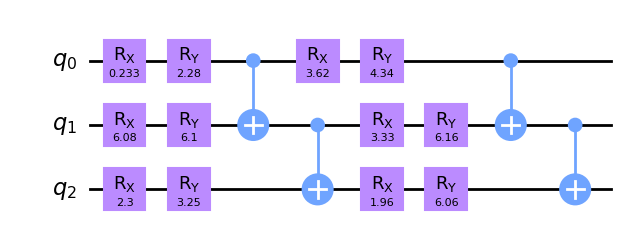

In [133]:
#State \rho_SR
size = 3
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [134]:
G1_SR = np.kron(np.kron(I, I), I)
G2_SR = np.kron(I, SWAP)

In [135]:
def createWernerMatrix(F):
    werner = np.zeros((4, 4), dtype=complex)
    werner += F*psiMinus
    werner += ((1-F)/3)*psiPlus
    werner += ((1-F)/3)*phiPlus
    werner += ((1-F)/3)*phiMinus

    return werner

In [175]:
def createWernerState(F):
    theta1 = 2*np.arccos(np.sqrt(0.667*(1-F)))
    theta2 = 2*np.arctan(np.sqrt(3*F/(1-F)))
    
    state = QuantumCircuit(3)
    state.ry(theta1, 0)
    state.append(CRYGate(theta2), [0, 1])
    state.x(0)
    state.ch(0, 1)
    state.x(0)
    
    return state

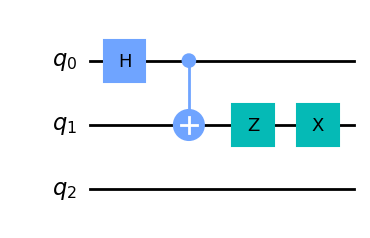

In [176]:
qcTest = QuantumCircuit(3)
qcTest.h(0)
qcTest.cx(0, 1)
qcTest.z(1)
qcTest.x(1)
qcTest.draw('mpl')

In [177]:
psi = np.array(DensityMatrix.from_instruction(createWernerState(0.5).reverse_bits()))
rho = pt(psi, [3], [2, 2, 2]) #rho_S
print(rho)

[[0.16675   +0.j 0.16675   +0.j 0.16668749+0.j 0.2887112 +0.j]
 [0.16675   +0.j 0.16675   +0.j 0.16668749+0.j 0.2887112 +0.j]
 [0.16668749+0.j 0.16668749+0.j 0.166625  +0.j 0.28860297+0.j]
 [0.2887112 +0.j 0.2887112 +0.j 0.28860297+0.j 0.499875  +0.j]]


In [178]:
shape = rho.shape

X = cp.Variable(shape, complex=True)
omega = cp.Variable(G2_SR.shape, complex=True)
G = cp.bmat([[createWernerMatrix(0.5), X.H],[X, pt(omega, [3], [2, 2, 2])]])

c = [omega>>0, G>>0, cp.real(cp.trace(omega))==1]

c.append(omega@G2_SR == G2_SR@omega)

obj = cp.Maximize(cp.real(cp.trace(X)))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

WARN: A->p (column pointers) not strictly increasing, column 80 empty
WARN: A->p (column pointers) not strictly increasing, column 107 empty
WARN: A->p (column pointers) not strictly increasing, column 116 empty
WARN: A->p (column pointers) not strictly increasing, column 143 empty
Root Fidelity is : 1.0000007528361223


In [179]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 1.0000015056728113
